In [6]:
import numpy as np
import pymc as pm
import arviz as az
import altair as alt
import matplotlib.pyplot as plt
import pandas as pd
from pymc.sampling_jax import sample_blackjax_nuts
import scipy.special as scs
from scipy.stats import ttest_ind
import simulations 
import plotting
import importlib
import extractors
import modelling
import statsmodels.api as sm
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", message=".*Pareto distribution.*")
warnings.filterwarnings('ignore', message=".*Your data appears to have a single value or.*")


WEEKDAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
rng = np.random.default_rng(42)
DEFAULT_WIDTH = 700

In [7]:
importlib.reload(plotting)
importlib.reload(simulations)
importlib.reload(extractors)
importlib.reload(modelling)

<module 'modelling' from '/home/aurimas/coding/blog-posts/drafts/tenure-effects/modelling.py'>

# Rethinking-inspired

For the past few months, I've been spending a lot of my time on following the [Statistical Rethinking course by Richard McElreath](https://github.com/rmcelreath/stat_rethinking_2023). I've heard good things about it before, and I wanted to get deeper into Bayesian workflows and get some exposure to causal inference - and it's rare to get a course that delivers both together. 

It was totally worth it. Not only the course helped me get much more comfortable with the topics covered, but its use goes beyond: the "owl drawing framework" / generative thinking is helpful in so many situations, and I have a bunch of topics I'd like to dive deeper into (state-space models in particular seem particularly exciting). 

It so happened that I had a problem at work that was nearly perfect to address using the techniques learned in the course. I figured I'll put a post together - perhaps some will find the problem itself interesting (it's a pretty common one in subscription-businesses, I suppose), others may get inspired to learn about Bayesian modelling themselves.

*P.S. Mid-way through the course, I started converting lecture materials & homeworks [into pyMC (5.X)](https://github.com/kamicollo/stat_rethinking_2023/tree/main/homework/my_solutions), too. Just in case that's handy for anyone (planning to clean them up & share more widely one day).*


# Problem at hand - estimating drop-off rate over tenure

Here's the problem I'll be solving in this post. Suppose you are in a business of providing a subscription-based service, where "success" means interacting with your service near daily. It could be pretty much anything - chatGPT, Spotify, Nexflix, a to-do app. Let's also suppose that the usage of your service exhibits quite strong seasonality. In this example, I'll be working with day-of-week effects but could also be anything from intra-day (hourly) to intra-year (monthly) effects. Additionally, suppose user signup patterns are also seasonal (i.e. we get many more signups on a some days of the week than on the others). Finally, just like any subscription service, you have a large fraction of users who just don't stick with your service - they try using it for a few days and drop off (even if they have at least a month of a committment).

Understanding the drop-off rate (you could call it "retention curve" - though it's not exactly retention) in such a business is very important. It helps inform decisions on "how long you have" to engage users before they start dropping off, it is one of the best ways to compare different signup cohorts, and it is a key input to customer lifetime value estimation.

## The descriptive approach

The simplest approach to getting such a curve is simple descriptive analysis. Suppose you have data on whether a user was active on your service for each of first 28 tenure days, for all users who joined in the last 3 months. You could simply calculate the average % of users who were active on the service on a daily basis and plot it to get a nice, smooth curve which you include in the presentation to the CEO and move on with your life.

In [73]:
##hide
n_users = 50_000


def standardize(x):
    return (x - x.min()) / (x.max() - x.min())

perfect_user_parameters = pd.DataFrame(dict(
    weekday = WEEKDAYS,        
    signup_weights = [1/7] * 7,
    intrinsic_motivation_baseline = [(30,10)] *7,
    intrinsic_motivation_adj = [(0,0)] * 7,
    newsletter_day_weights = [0.0, 0.0, 0.0, 0.0, 0., 0.7, 0.3]
)).set_index('weekday')


perfect_activity_parameters = {
    'tenure_curve': lambda x: standardize(-4 / (x +1) ** 0.1),
    'full_tenure_impact': [-0.5],
    'weekday_impact': np.array([0] * 7),
    'newsletter_day_impact': 0.1,
    'tenure_length': 28
}

perf_users = simulations.simulate_users(n_users, perfect_user_parameters, rng=rng)
perf_activity, perf_pct_cutoff = simulations.simulate_activity(
    perf_users, perfect_activity_parameters, rng=rng
)

In [74]:
perfect_curves = plotting.basic_eda(perf_activity)
perfect_curves[0].width = DEFAULT_WIDTH
perfect_curves[0].title = "A nearly perfect drop-off curve"
perfect_curves[0].display()

alt.Chart(...)

There's just one potential problem. Your curve may instead look like this:

In [105]:
##hide 

realistic_user_parameters = pd.DataFrame(dict(
    weekday = WEEKDAYS,        
    signup_weights = [0.05, 0.15, 0.1, 0.1, 0.30, 0.25, 0.05],
    intrinsic_motivation_baseline = [(30,10)]*7,
    intrinsic_motivation_adj = [(0,0)] * 7,
    newsletter_day_weights = [0.0, 0.0, 0.0, 0.0, 0., 0.7, 0.3]
)).set_index('weekday')


realistic_activity_parameters = {
    'tenure_curve': lambda x: standardize(-4 / (x +1) ** 0.1),
    'full_tenure_impact': [-0.5],
    'weekday_impact': np.array([0.08, 0.05, 0.02, 0, 0, -0.05, -0.1]),
    'newsletter_day_impact': 0.1,
    'tenure_length': 28
}
   
real_users = simulations.simulate_users(n_users, realistic_user_parameters, rng=rng)
real_activity, real_pct_cutoff = simulations.simulate_activity(
    real_users, 
    realistic_activity_parameters, rng=rng
)

In [76]:
realistic_curves = plotting.basic_eda(real_activity)
realistic_curves[0].width = 700
realistic_curves[0].title = "Not so perfect drop-off curve"
realistic_curves[0].display()

alt.Chart(...)

That sort of shape should give you a pause before putting it into a presentation. 

Here's the thing - both curves are calculated from datasets where the underlying tenure effect is the same. In the first scenario, we have no seasonality. Every day of the week attracts the same number of signups and users are just as likely to visit the service on any day, too. In the second scenario that's not the case.

## The data generating process

One of the very useful things I took away from the Statistical Rethinking course is that generating your own data when designing models can be very helpful. If your model cannot recover true parameters with a simplified, fake dataset, you have no chance with real data. If it can - that's good, and now you have a foundation to explore when "things get more complicated".

The above data (just like all the data in this post) was simulated. Here's the setup:

 * I draw 100,000 of users who have 3 attributes: 
   * Signup day of week. I can control the proportions of users across signup and days
   * Intrinsic motivation, which I can't ever observe in real life, but I hypothesise that users come to the service with different motivation levels. I represent that as a 0-1 variable (you can think of it as "baseline probability to engage with the service"), which I obtain by drawing from Beta distribution with parameters α=30, β=10 (so the average intrinsic motivation is ~0.75). 
   * User's newsletter day of the week. Just to make things a bit more interesting, I imagine each user gets a newsletter (which increases their chance of using the service on the given day), but the day the user may get the newsletter varies.
 * Once I have drawn the users, I then simulate their activity data. Each day, I draw a Bernoulli variable with `p` probability of success, where `p` is a function of intrinsic motivation baseline, a tenure effect, a day of week effect, and a newsletter effect (if the day is the newsletter day for the user). For simplicity purposes, I simply sum up the effects. In the cases when the final probability `p` is very low (<0.01) or high (>0.99), I set it to 0.01 and 0.99, respectively, so that it's never 100% certain if a user will use the service or not. 
   * Day of week and newsletter day effects are just numeric values I set arbitrarily. The newsletter day effect is 0.1; day of week effects are plotted below.
   * I model tenure effect in two components. First, I produce a curve using a function $f(x)= \frac{-4}{x ^{0.01}}$, where $x$ is a tenure day, then I rescale it to 0-1 range, and finally I apply an overall tenure effect. In a nutshell, I get a a smooth tenure effect which starts at 0 and reaches the overall effect by the last tenure day.

Here's a few quick visualizations of the parameters.

In [12]:
all_params = pd.concat([
    extractors.parse_parameters(perfect_user_parameters, perfect_activity_parameters, 'Scenario 1', WEEKDAYS),
    extractors.parse_parameters(realistic_user_parameters, realistic_activity_parameters, 'Scenario 2', WEEKDAYS)
])

plotting.plot_all_params(all_params)

alt.VConcatChart(...)

In [13]:
def motivation_bins(users, source):
    freq = pd.DataFrame(
        pd.cut(users['intrinsic_motivation'], np.linspace(0, 1, 101)).value_counts()
    ).reset_index(names='bin')

    freq['source'] = source
    freq['bin'] = freq['bin'].apply(lambda x: float(x.left)).astype(float)
    freq['intrinsic_motivation'] = freq['intrinsic_motivation'] / freq['intrinsic_motivation'].sum()
    return freq.rename({'intrinsic_motivation': 'density'}, axis=1)

frequencies = pd.concat([motivation_bins(perf_users, 'Scenario 1'), motivation_bins(real_users, 'Scenario 2')])

alt.Chart(frequencies).mark_line().encode(
    alt.X('bin', title='Intrinsic motivation'), alt.Y('density'), alt.Color('source')
).properties(title='User intrinsic motivation distribution')

alt.Chart(...)

## More problems with the descriptive approach

Now that the data generating process is clear, I can point out a couple of other dangers with simple summary statistics. Not only the drop-off curve is wiggly, but a simple analysis that averages users active on a given day of the week yields strange effects. 

It looks like there's a bump in activity on Friday vs. Thursday, but if you were to look back at actual weekday effects, they have been setup so that we progressively have less activity throughout the week. Newsletter effects are not applicable either (they only take place on Saturdays and Sundays). That bump is just a function of unequal signup weights again. 

Similarly, one could read into the third chart and conclude that there are some differences among users signing up on different days of the week (perhaps their motivation levels are different?), while we know that the data generating process does not actually include any assumptions about that. In fact, you could even run a t-test on average # of active days between users who signed up on Monday vs. Sunday, and find that the p-value is just below 0.2. It may be enough to conclude "there's something to it" in some situations.

In [14]:
realistic_curves[0].width = 400
realistic_curves[0] | realistic_curves[1] | realistic_curves[2]

alt.HConcatChart(...)

## Uncovering the truth with a bit of data science

This problem is a good example of something that would typically land on a data analyst's desk, not a data scientist's one. However, getting the right answers requires a bit of "data science" (which is why, in my view, a good data analyst needs to know statistics & ML; it's just that their focus is on different kind of problems).

Let's see if we can uncover the true data generating parameters using some statistics. As we care about interpretability, we'll have to stick to regressions. This is inherently a logistic regression problem ("will a user visit on day X?"), which can also be expressed as a binomial regression as long as we don't care about user-specific parameters or group observations into groups that share the same characteristics. For comparison, let's use both a Bayesian approach (using `pymc`) and a more usual MLE one (`statsmodels` package).

In [15]:
base_group_df = modelling.make_groups(real_activity) #convert the observations into groups delineated by variables of interest
base_group_df.head()

,day_of_week,tenure_day,visited,total_users,is_newsletter_day,signup_day_of_week,not_visited
0,Mon,1,2000,2473,0,Mon,473
1,Tue,1,5938,7411,0,Tue,1473
2,Wed,1,3903,5021,0,Wed,1118
3,Thu,1,3891,5136,0,Thu,1245
4,Fri,1,11220,14980,0,Fri,3760


### Modelling Tenure effects

Most of the model specification here is quite straightforward - we want an intercept, plus indicator variables to capture day-of-week and signup-day effects. There are more complex approaches one could take - for example, if you believe that day-of-week effects are likely more similar between Monday and Tuesday than between Monday and Saturday, you could capture that via a Gaussian Process prior in a Bayesian setting - but I'll stick to these.

What about tenure effects, however? I'll explore 3 possibilities:
* MLE option #1 - I'll treat days as a continuous variable, and fit a single parameter. While it's linear in logit space, it's not linear in probability space and may be good enough to capture what's needed.
* MLE option #2 - I'll treat days as a discrete variable, with each day getting a dummy indicator.
* Bayesian model - I'll treat days as a discrete ordinal variable, and force a monotonic effect. This is one of my favourite aspects about Bayesian modelling - if I have some specific domain assumptions I want to make, I can bake them into the model. I'll enforce that by modelling tenure effects as $T_n = β * \sum_{i=1}^{n}{p_i}$, where `β` represents the full tenure impact, and `p` is the proportion that a tenure day `n` contributes. This can be easily achieved with a Dirichlet prior on `p`. 

### MLE model specifications

In a nutshell, the MLE models I end up with are:
* MLE #1: `visits | days ~ α + β*tenure_day + I(day_of_week) + I(signup_day_of_week) + I(is_newsletter_day)`
* MLE #2: `visits | days ~ α + I(tenure_day) + I(day_of_week) + I(signup_day_of_week) + I(is_newsletter_day)`

The only thing to keep in mind is that I have to drop one of the levels in each of the dummies (I chose to drop tenure day 1 and Monday when it comes to day-of-week variables), so the intercept will represent "visits on a Monday on 1st tenure day" in case of the first model, and "visits on a Monday" in the second model.

### Bayesian model specification

When it comes to the Bayesian model, the approach will be similar, but with a few tweaks:

* Instead of having "Monday, tenure day 1" as a reference baked into the intercept, I'll model the day of week effects (both signup day and active day) as hierarchical, sharing a common underlying intercept. Not only this allows me to avoid choosing an arbitrary reference value, but I can capture any correlation between day-of-week parameters.
  
* I will force the tenure effects to be monotonic, as already described above.

These structural assumptions that will make the Bayesian model behave a bit differently than the MLE one. 

There's also priors to specify:

* For the underlying intercept `α`, I will go with a prior `N(0.5,2)`. As α is on a logit space, this corresponds to a base probability of observing a visit of 63% and is wide enough to cover pretty much entire 0-1 space. I want to set the mean to above zero given I believe that the motivation (== likelihood to log in on day 1) is definitely above 50%. 
  
* For each of the signup day, day of week, I will use a prior `N(0, 0.5)`. I don't have strong beliefs that these effects are positive or negative (thus mean of zero), but I do think that the effects, if any, are unlikely to be dramatic. ~95% of `N(0, 0.5)` observations fall into range `[-1, 1]`, which, for an average `α`, means I expect that these effects can individually move the base probability from 50% to as low as 26% (`invlogit(-1)`) or up to 73%. That sounds quite reasonable to me. 
  
* For newsletter day effect, I pick a prior `N(1, 0.5)`. This is basically a belief that a result should be positive, but I am not sure by how much, as this prior largely explores the `[0; 2]` logit space. 
  
* I believe that the tenure effect `β` is negative, and quite strongly so - it represents the decrease in base probability of a visit by tenure day 28. I'll set a prior to `Normal(-2, 1)`, which translates to an expectation of 11% visit probability by day 28. As its standard deviation is 1, it will largely explore space between [0, -4], which represents my belief that such an effect should be negative. An alternative could be to force it to be negative using an `-Exp()` prior.
  
* Reasoning about priors for `p ~ Dirichlet()` is not straightforward, as we also need to take `α` and `β` parameters into account, and this is all in the logit space. The easiest is to draw from priors and see what happens. It turns out that `p ~ Dirichlet(1, 1, 1.... 1)` is a very reasonable prior, so I will stick with that, though as it's quite clear in the illustrations below, other choices may be more appropriate depending on your beliefs.
  
* Because the hierarchical effects are multivariate, there's also a prior on the correlation structure between them to specify. I am using the `pymc.LKJCholeskyCov` for a non-centered parameterization, which requires an `η` parameter to specify beliefs about correlation strenghts. After doing a similar simulation, I chose `η=2`, as it represents a prior concentrated in [-0.75; 0.75] space. For comparison, `η=1` is a flat prior, while  `η=4` is concentrated in the [-0.5, 0.5] space, and `η=10` in the [-0.25; 0.25] space.

In [16]:
priors = {
    'η': 2,
    'α': (0.5, 2),
    'S': (0, 0.5),
    'N': (1, 0.5),
    'p': np.ones(28 - 1),
    'β': (-2, 1)
}

plotting.plot_tenure_priors(realistic_activity_parameters, prior_set = priors)

alt.VConcatChart(...)

How much do these precise choices matter? That's something I'll explore in this post. Besides using the "hand-picked" priors listed above, I will also see what happens if I just set `N(0,5)` priors for most parameters.

In [17]:
wider_priors = {
    'η': 2,
    'α': (0, 5),
    'S': (0, 5),
    'N': (0, 5),
    'p': np.ones(28 - 1),
    'β': (0, 5)
}

Now, I have to admit I did not immediately come up with the handpicked priors above. I kept on fiddling with them while writing this post. One helpful tool in that process was prior predictive simulations. The idea is that you sample from the priors and see what kind of predictions your model arrives before it even tries to learn any parameters. It's similar to what I did when exploring how to set Dirichlet prior earlier, but with focus on predictions. PyMC provides an easy way to obtain prior predictive samples with `pm.sample_prior_predictive()`.

A distribution of predictive values themselves are not that interesting. What helped me the most was to visualize them along a data (conditional distributions). Specifically, I chose to do that along tenure - after all, that's the most interesting aspect in this case study. Below, you can see the distribution of success probability obtained at each tenure day by sampling from the two set of priors.

In [20]:
def predicted_probs_by_tenure(model, data, source):
    pr_pred = pm.sample_prior_predictive(model = model, samples=2000)
    X = data.copy() 
    X['predictions'] = pr_pred['prior_predictive']['likelihood'].to_numpy().swapaxes(2, 0).squeeze().tolist()
    X['preds'] = X[['predictions', 'total_users']].apply(lambda x: (np.array(x[0]) / x[1]).tolist(), axis=1)
    predicted_probabilities = pd.DataFrame(X.groupby('tenure_day')['preds'].sum()).reset_index().explode('preds')
    predicted_probabilities['bin'] = pd.cut(predicted_probabilities['preds'], np.linspace(0, 1, 21))

    freq = predicted_probabilities.groupby(['tenure_day', 'bin']).count().reset_index()
    freq['bin'] = freq['bin'].apply(lambda x: float(x.left)).astype(float)    
    freq['source'] = source
    return freq.rename({'preds': 'density'}, axis=1)

base_model = modelling.compile_pymc(base_group_df, hierarchical=True, priors=priors, model_with_offset=False)
wider_model = modelling.compile_pymc(base_group_df, hierarchical=True, priors=wider_priors, model_with_offset=False)

base_frequencies = predicted_probs_by_tenure(base_model, base_group_df, 'Base model')
wider_frequencies = predicted_probs_by_tenure(wider_model, base_group_df, 'Wider priors')


Sampling: [Z, chol_cov, likelihood, newsletter_day, tenure_prop, α, β]
Sampling: [Z, chol_cov, likelihood, newsletter_day, tenure_prop, α, β]


In [21]:
comb_frequencies = pd.concat([base_frequencies, wider_frequencies])

alt.Chart(comb_frequencies[comb_frequencies['tenure_day'].isin([1,7,14,21,28])]).mark_line().encode(
    alt.X('bin', title="P(visit)", axis=alt.Axis(grid=False)), alt.Y('density', axis=alt.Axis(grid=False)), 
    alt.Facet('tenure_day', spacing={'row': 3, 'column': 5}),
    alt.Color('source')
).properties(height=100, width=100)

alt.Chart(...)

Suddenly, it's crystal clear why wide priors may make inference difficult. They effectively imply that the visit probability is highly bimodal, and I can see why it may make the sampler work overtime. It also shows that my current prior choice could be further improved. While it seems to work well in early and late tenure days, I expected to see a bell-like curve in mid-tenure days; instead, the prior choices yield a largely uniform probability. 

Turns out, to achieve such a shape, all I need is to reduce the variance of the intrinsic motivation prior from `N(0.5, 2)` to `N(0.5, 0.7)`. I found prior predictive simulations in the prior setting process very powerful!

In [22]:
bell_shaped_priors = {
    'η': 2,
    'α': (0.5, 0.7),
    'S': (0, 0.5),
    'N': (1, 0.5),
    'p': np.ones(28 - 1),
    'β': (-2, 1)
}

sc2_bell_shape_prior_model = modelling.compile_pymc(base_group_df, hierarchical=True, priors=bell_shaped_priors, model_with_offset=False)
bell_shaped_frequencies = predicted_probs_by_tenure(sc2_bell_shape_prior_model, base_group_df, 'Bell-shape targeting priors')

Sampling: [Z, chol_cov, likelihood, newsletter_day, tenure_prop, α, β]


In [23]:
comb_frequencies = pd.concat([base_frequencies, bell_shaped_frequencies])
alt.Chart(comb_frequencies[comb_frequencies['tenure_day'].isin([1,7,14,21,28])]).mark_line().encode(
    alt.X('bin', title="P(visit)", axis=alt.Axis(grid=False)), alt.Y('density', axis=alt.Axis(grid=False)), 
    alt.Facet('tenure_day', spacing={'row': 3, 'column': 5}),
    alt.Color('source')
).properties(height=100, width=100)

alt.Chart(...)

This is how the final pyMC model looks like (less deterministic variables that I use for calculating marginal effects).

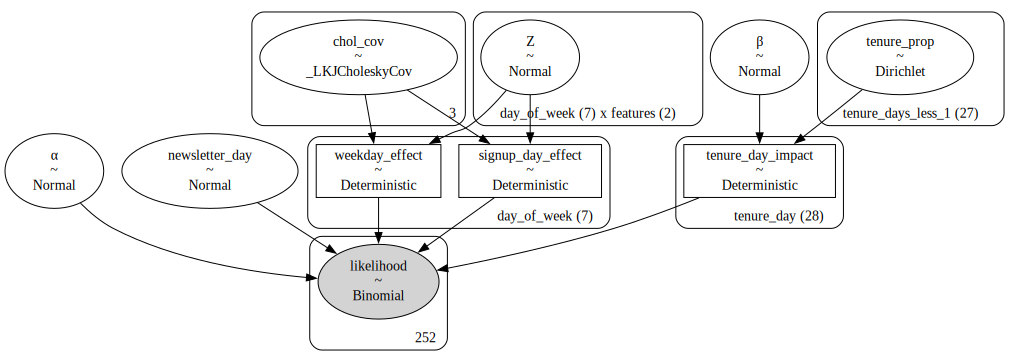

In [24]:
pm.model_to_graphviz(base_model, var_names=['likelihood'])

### Running the models

Let's go ahead and run the models. The MLE models run in sub-second, you don't even need to think about it. When it comes to pyMC model, even using the blackjax sampler (which is much faster than the pyMC built-in one), it still takes ~25 seconds. Not too bad, but not exactly instantenous. 

Additionally, as Bayesian models require a bit more care, let's have a look at the r-hat statistics for key variables and their trace plots to make sure that the model converged.

In [25]:
#fitting the two MLE models
res_discrete = modelling.fit_mle(base_group_df, discrete_tenure = True)
res_cont = modelling.fit_mle(base_group_df, discrete_tenure = False)

In [26]:
#fitting the pyMC model
base_trace = modelling.fit_pymc(rng=rng, model = base_model)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


alt.LayerChart(...)

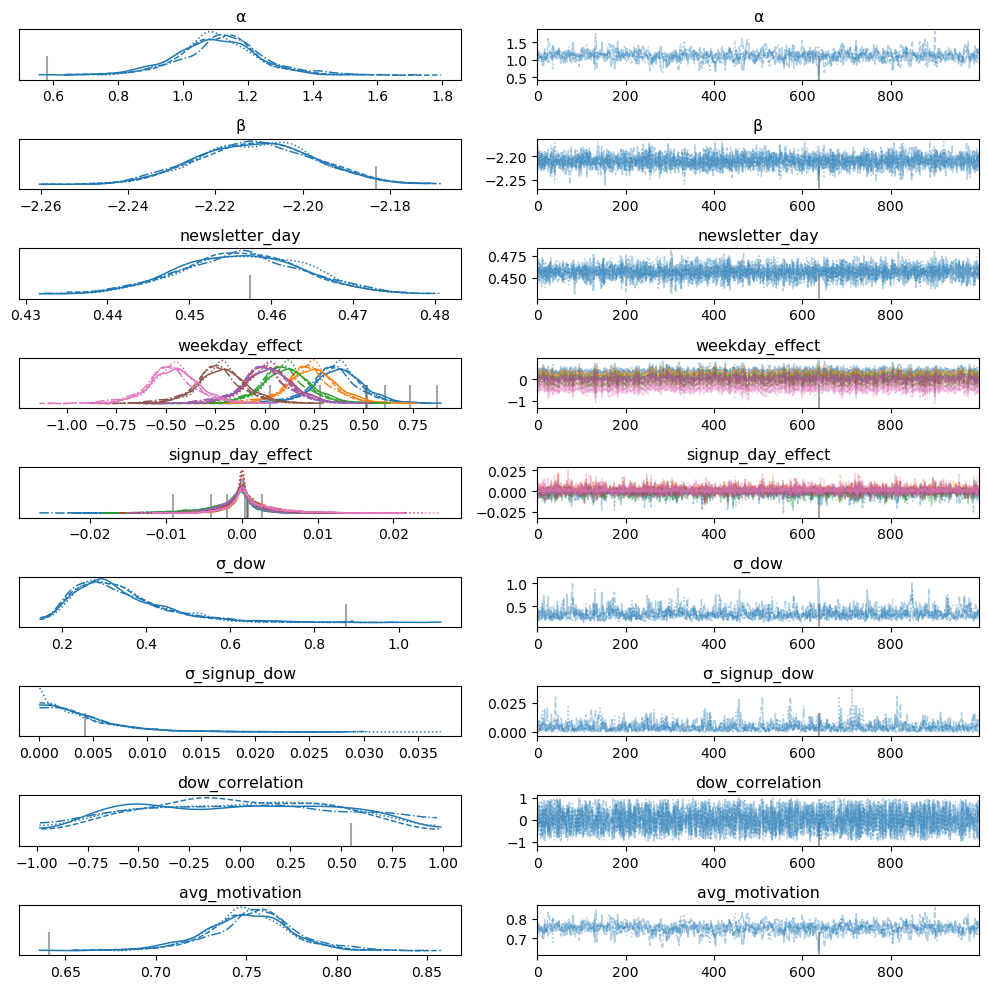

In [27]:
plotting.plot_rhats(base_trace).display()
plotting.plot_trace(base_trace)

There are some divergences, but nothing too worrisome - let's proceed to comparing what the models learned.

### Comparing the model performance

As it can be seen from the plots below, both the discrete MLE approach and the Bayesian one yield very similar results. Bayesian model is more certain about signup effects being zero, and is a bit less off when estimating the newsletter impact. But overall, both models perform great.

The continuous MLE model, on the other hand, struggles with capturing the tenure effects. The linear specification just doesn't cut it here. Perhaps a more creative approach (log- or polynomial specification) may work better. The upside is that it is most precise in capturing newsletter and day of week effects.

In [28]:
importlib.reload(extractors)
importlib.reload(plotting)

traceExt = extractors.TraceExtractor(base_trace, name='Bayes')
gtExt = extractors.TrueParameterExtractor(realistic_user_parameters, realistic_activity_parameters, 'Ground truth', WEEKDAYS)
SMExt_discrete = extractors.StatsModelExtractor(res=res_discrete, name='MLE discrete', tenure_discrete=True)
SMExt_cont = extractors.StatsModelExtractor(res=res_cont, name='MLE continuous', tenure_discrete=False)


all_effects = pd.concat([
    traceExt.extract_all_effects(offset=True),
    gtExt.extract_all_effects(offset=True),
    SMExt_discrete.extract_all_effects(),
    SMExt_cont.extract_all_effects()
])

plotting.plot_all_effects(all_effects)

alt.VConcatChart(...)

So is the effort in setting up the Bayesian model worth it? Well, it definitely did better than the continuous MLE model; but the performance compared to the discrete MLE model is nearly identical. It looks like we did not benefit that much from the structures built into it. 

The only real advantage is that we were able to estimate the baseline motivation, and the model also learned that there is a lot of variation in it. If fact, the model is still overly confident about it: the 95% credible interval spans roughly 0.7-0.8 range, while in reality the data generation process implies a broader range (you can look back at the user motivation histogram above for a visual illustration).

### Beware of correlations
Talking about uncertainty: this turns out a great example of why correlation in Bayesian models matter. If you revisit the trace plots, it may strike you as surprising that the Bayesian model has low uncertainty about day of week and signup day effects in the marginal effects plots. Specifically, if let's look at the uncertainty of the offset parameters that represent the difference from intercept:

In [29]:
az.summary(base_trace, var_names='Z', coords={'features': 'day_of_week'})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Z[Mon],1.184,0.494,0.294,2.169,0.017,0.012,878.0,1215.0,1.00
Z[Tue],0.756,0.424,-0.065,1.562,0.015,0.011,814.0,1026.0,1.00
Z[Wed],0.335,0.383,-0.415,1.052,0.014,0.010,760.0,1125.0,1.01
Z[Thu],0.045,0.375,-0.699,0.740,0.014,0.010,722.0,1235.0,1.01
Z[Fri],0.023,0.375,-0.684,0.741,0.014,0.010,714.0,1212.0,1.01
Z[Sat],-0.733,0.440,-1.590,0.054,0.016,0.012,712.0,1310.0,1.00
Z[Sun],-1.518,0.591,-2.588,-0.365,0.021,0.015,761.0,1296.0,1.00


Standard deviations are at least 0.4. So how come that is not visible in the marginal effects plot? Well, it turns out that the parameters are highly correlated. Whenever in the trace the Monday effect is high, so is the Friday one, and thus the marginal effect that reflects the difference between Monday and Friday is small. We can clearly see that in the pair-wise correlation plots.

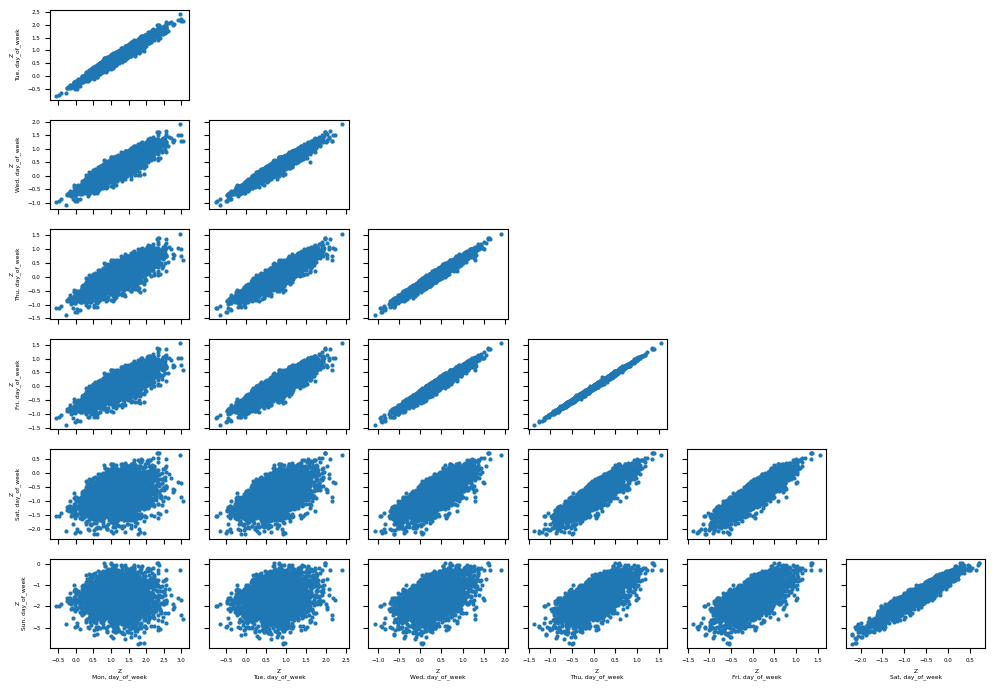

In [30]:
az.plot_pair(base_trace, var_names='Z', coords={'features': ['day_of_week']}, figsize=(10,7), textsize=4)
plt.tight_layout()
plt.show()

The takeaway here is twofold:
* The model may benefit from a specification similar to the one in MLE (setting a reference day). We would lose the ability to measure the underlying motivation, but it would reduce correlations among variables, which may help with sampling. 
* It's important to compute the effects we care about. Below I visualize seemingly the same thing: the "effect of a day of a week", but in one chart I show it against baseline motivation, while in the other I use Monday as the reference. While point estimates are comparable, the uncertainty looks very different! That's because it represents a different kind of uncertainty.

In [31]:
alt.hconcat(
    plotting.plot_effects(traceExt.extract_dow_effects(offset=True), 'day_of_week', 'DoW effect (vs. Monday)', WEEKDAYS), 
    plotting.plot_effects(traceExt.extract_dow_effects(offset=False), 'day_of_week', 'DoW effect (vs. baseline)', WEEKDAYS)
)

alt.HConcatChart(...)

### Picking the best specification

So how to pick whether to use an offset-based model or not? I'll turn to leave-one-out cross-validation for Bayesian models (expected log pointwise predictive density (ELPD)). Let's compare four models: hierarchical vs. not (where day-of-week effects are effectively specified the same way as in MLE model, as indicator variables), with offset specification or not.

In [32]:
base_trace_non_h = modelling.fit_pymc(
    model = modelling.compile_pymc(base_group_df, hierarchical=False, priors=priors, model_with_offset=False), 
    rng=rng,
)
base_trace_offset = modelling.fit_pymc(
    model = modelling.compile_pymc(base_group_df, hierarchical=True, priors=priors, model_with_offset=True), 
    rng=rng    
)  
base_trace_non_h_offset = modelling.fit_pymc(
    model = modelling.compile_pymc(base_group_df, hierarchical=False, priors=priors, model_with_offset=True), 
    rng=rng    
)

When computing comparisons, I get a warning that _"Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples."_. Looking closer, it seems that there are a few observations in the model where k-pareto values are between 0.7 and 1. Is that concerning? Well, clearly it could be better. However, I found a note from [Aki Vehtari in STAN forums](https://discourse.mc-stan.org/t/a-quick-note-what-i-infer-from-p-loo-and-pareto-k-values/3446/1) where he provides some rules of thumb, and it seems my scenario falls into the least bad situation (p_loo << number of parameters AND number of parameters > n/5). It could be that better priors would make the issue go away.

Setting k-pareto values aside, looks like the hierarchical models perform the best, with nearly no difference between offset and non-offset specification. So I'll continue using the hierarchical non-offset version as the basis.

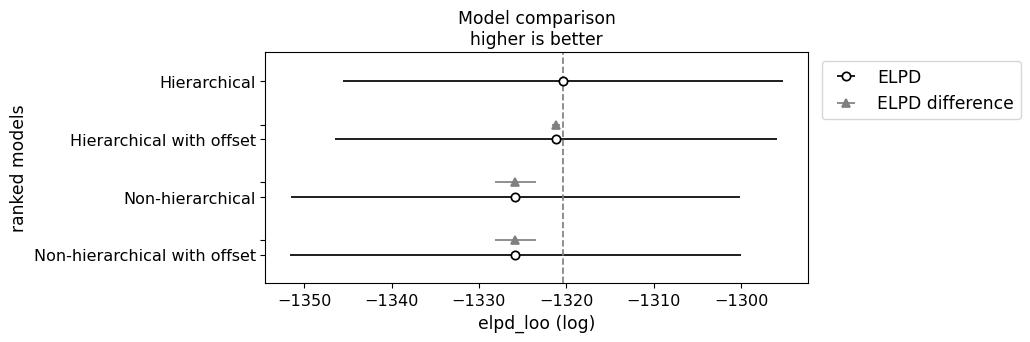

In [33]:
comparison = az.compare(
    {'Hierarchical': base_trace, 
     'Hierarchical with offset': base_trace_offset, 
     'Non-hierarchical': base_trace_non_h, 
     'Non-hierarchical with offset': base_trace_non_h_offset
     }, ic='loo'
)
az.plot_compare(comparison, figsize=(7,3))
plt.show()

### Do priors matter?

I promised to try out a wider set of priors, where instead of carefully thinking about all effects, I set `N(0,5)` priors for all applicable parameters. What happens then? Turns out that:
* The model still converges (r-hat values < 1.03);
* However, there are many more divergences (the sampler is rejecting unlikely values)
* Inference results are largely identical.

alt.LayerChart(...)

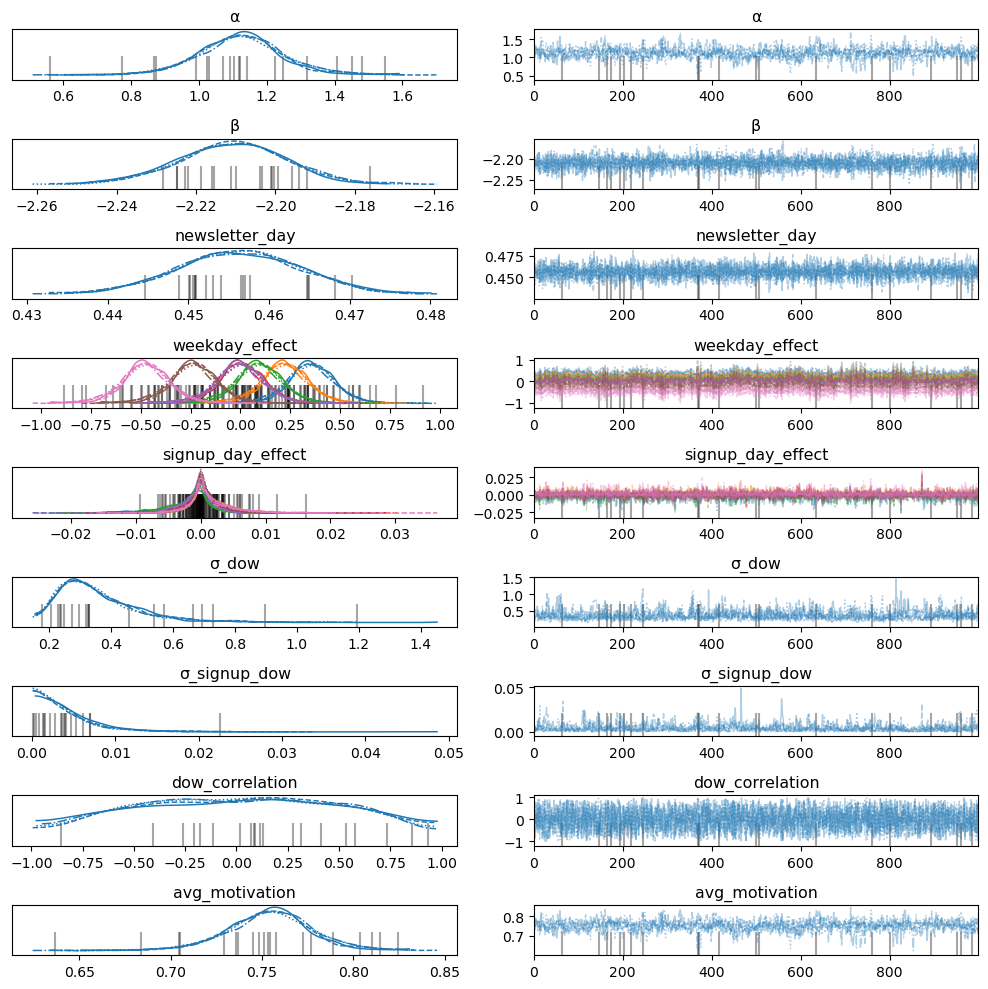

In [34]:
wide_trace = modelling.fit_pymc(wider_model, rng)
plotting.plot_rhats(wide_trace).display()
plotting.plot_trace(wide_trace)

In [35]:
traceExtWide = extractors.TraceExtractor(wide_trace, name='Bayes - flatter priors')

all_effects = pd.concat([
    traceExt.extract_all_effects(offset=True),
    traceExtWide.extract_all_effects(offset=True)
])

plotting.plot_all_effects(all_effects)

alt.VConcatChart(...)

# Modelling a more difficult scenario

The data used so far had no signup-day effects. Would the models be able to recover them if there were any? Also, the data had a lot of signal. What if we reduce the size of the tenure effect to make it harder to figure out what is what?

In [67]:
##hide 

sc2_user_params = realistic_user_parameters.copy(deep=True)
sc2_activity_params = realistic_activity_parameters.copy()
sc2_user_params['intrinsic_motivation_adj'] = [(0,0), (-5, 0), (-10, 0), (-10, 0), (10, 0), (20, 0), (30, 10)]
sc2_activity_params['full_tenure_impact'] = [-0.1]

   
sc2_users = simulations.simulate_users(n_users, sc2_user_params, rng=rng)
sc2_activity, _ = simulations.simulate_activity(
    sc2_users, 
    sc2_activity_params, rng=rng
)

In [77]:
importlib.reload(extractors)
all_params = pd.concat([
    extractors.parse_parameters(sc2_user_params, sc2_activity_params, 'Scenario 2', weekdays=WEEKDAYS),
    extractors.parse_parameters(realistic_user_parameters, realistic_activity_parameters, 'Baseline scenario', weekdays=WEEKDAYS),    
])

#plot_all_params(all_params)
alt.hconcat(
    plotting.plot_effects(all_params, 'signup_day_of_week', 'Signup day of week effects', sort=WEEKDAYS),
    plotting.plot_effects(all_params, 'tenure_day', 'Tenure effects')
)


alt.HConcatChart(...)

I fit two MLE models as before, as well as two Bayesian ones - using my hand-picked priors as well as the wider ones.

In [78]:
importlib.reload(modelling)
sc2_group_df = modelling.make_groups(sc2_activity)

In [79]:
#fitting the two MLE models
sc2_res_discrete = modelling.fit_mle(sc2_group_df, discrete_tenure = True)
sc2_res_cont = modelling.fit_mle(sc2_group_df, discrete_tenure = False)

In [80]:
#fitting the pyMC models (hand-picked priors)
sc2_base_model = modelling.compile_pymc(sc2_group_df, hierarchical=True, priors=priors, model_with_offset=False)
sc2_trace = modelling.fit_pymc(rng=np.random.default_rng(52), model = sc2_base_model)

In [81]:
#fitting pyMC model (wide priors)
sc2_wide_model = modelling.compile_pymc(sc2_group_df, hierarchical=True, priors=wider_priors, model_with_offset=False)
sc2_wide_trace = modelling.fit_pymc(rng=np.random.default_rng(52), model = sc2_wide_model)

### Solving convergence issues 

However, the Bayesian models do not converge.

In [82]:
alt.hconcat(
    plotting.plot_rhats(sc2_trace).properties(title='Handpicked priors'),
    plotting.plot_rhats(sc2_wide_trace).properties(title='Wide priors')
)

alt.HConcatChart(...)

A peek into the trace shows that 3 out of 4 chains actually converged nicely. However, the last one got completely stuck.

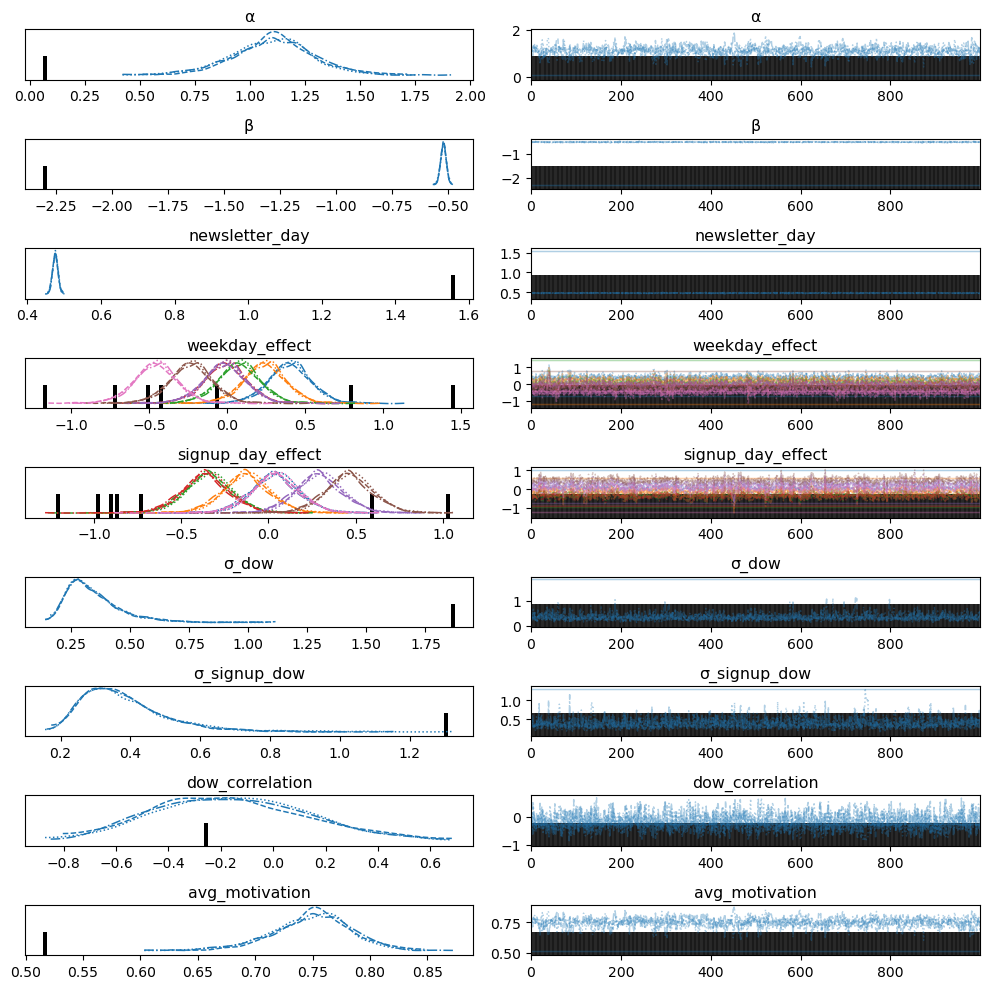

In [83]:
plotting.plot_trace(sc2_trace)

I spent a LOT of time understanding what happens, and I may write it up as a separate blog post. As MCMC is stochastic, debugging was quite a bit of pain. Models would seemingly converge until they would not. One set of priors would work on a given day and not on the other day. In the end, the main learnings I took away were (in order of importance):
* Chains getting completely stuck was the main issue. Increasing `target_accept` parameter (decreasing "step size" in the HMC algorithm) helped solve this issue. I suppose this issue was conceptually similar to a gradient descent getting stuck in a local optima when the step size / learning rate is too high.
* Using wider priors would increase the risk of problematic divergences. This behavior was similar to what was already visible in the initial scenario, but the scale of the problem went up.
* My initial prior set wasn't the best given the new dataset as it encoded an assumption of strong tenure effects (`β ~ N(-2, 1)`). While it did not have a major effect, using something like `β ~ N(-1, 0.5)` yielded the "nicest" traces.

Let's refit the model using `target_accept=0.95` and a set of handpicked priors (where `β ~ N(-1, 0.5)`).

In [84]:
adjusted_priors = {
    'η': 2,
    'α': (0.5, 2),
    'S': (0, 0.5),
    'N': (1, 0.5),
    'p': np.ones(28 - 1),
    'β': (-1, 0.5)
}

In [135]:
importlib.reload(modelling)
#fitting the pyMC models (hand-picked priors)
sc2_adj_model = modelling.compile_pymc(sc2_group_df, hierarchical=True, priors=adjusted_priors, model_with_offset=False)
sc2_adj_trace = modelling.fit_pymc(rng=np.random.default_rng(52), model = sc2_adj_model, target_accept=0.95)

In [136]:
plotting.plot_rhats(sc2_adj_trace).properties(title='Adjusted priors with target_accept=0.95')

alt.LayerChart(...)

### Result time

How do the models perform? Again, the performance is very similar between the MLE discrete and the Bayesian model (and MLE continuous approach just doesn't work..)

In [137]:
sc2_traceExt = extractors.TraceExtractor(sc2_adj_trace, name='Bayes (handpicked priors)')
sc2_gtExt = extractors.TrueParameterExtractor(sc2_user_params, sc2_activity_params, 'Ground truth', WEEKDAYS)
sc2_SMExt_discrete = extractors.StatsModelExtractor(res=sc2_res_discrete, name='MLE discrete', tenure_discrete=True)
sc2_SMExt_cont = extractors.StatsModelExtractor(res=sc2_res_cont, name='MLE continuous', tenure_discrete=False)


all_effects = pd.concat([
    sc2_traceExt.extract_all_effects(offset=True),
    sc2_gtExt.extract_all_effects(offset=True),
    sc2_SMExt_discrete.extract_all_effects(),
    sc2_SMExt_cont.extract_all_effects(),    
])

plotting.plot_all_effects(all_effects)

alt.VConcatChart(...)

I think it's worth zooming into tenure effects. This is a good illustration where the extra structure in the Bayesian model finally starts to pay off. While the Bayesian model does not recover a perfectly smooth curve, it, by design, is monotonic. On the other hand, the MLE model is clearly affected by noise.

In [138]:
alt.hconcat(
    plotting.plot_effects(
    sc2_traceExt.extract_all_effects(offset=True),
    'tenure_day', title='Tenure day effects', sort=list(range(1,28))
    ).properties(height=300),
    plotting.plot_effects(
    sc2_SMExt_discrete.extract_tenure_effects(),
    'tenure_day', title='Tenure day effects', sort=list(range(1,28))).properties(height=300)
)

alt.HConcatChart(...)

# Modelling varying tenure effects

The last scenario I want to explore is where user motivation has a stronger impact on tenure effects. So far, the data generation process assumed that:
* A user has an intrinsic motivation level `α`
* A fixed tenure impact `β`, which is spread over the tenure period.

In real world, however, it's probably not how motivation works. If you are motivated, then you don't only have a higher initial motivation level; you likely also lose less motivation over time (`β` is smaller in absolute size). Let's generate the last dataset where `β` varies by signup day of the week, similar to how `α` is modelled. 

In [89]:
##hide 
sc3_user_params = realistic_user_parameters.copy(deep=True)
sc3_activity_params = realistic_activity_parameters.copy()
sc3_user_params['intrinsic_motivation_adj'] = [(0,0), (-5, 0), (-10, 0), (-10, 0), (10, 0), (20, 0), (30, 10)]
sc3_activity_params['full_tenure_impact'] = [-0.5, -0.6, -0.7, -0.65, -.4, -.3, -.25]

   
sc3_users = simulations.simulate_users(n_users, sc3_user_params, rng=rng)
sc3_activity, _ = simulations.simulate_activity(
    sc3_users, 
    sc3_activity_params, rng=rng
)

In [132]:
sc3_gtExt = extractors.TrueParameterExtractor(sc3_user_params, sc3_activity_params, 'Ground truth', WEEKDAYS)
alt.Chart(
    sc3_gtExt.extract_tenure_effects(offset=False, multi=True)
).mark_line().encode(
    alt.X('values', title='tenure day'), 
    alt.Y('impact', title='Δ visit probability'), 
    alt.Color('factor', sort=WEEKDAYS, title='day of signup')
).properties(title='Varying tenure effects (as a function of day of signup)')

alt.Chart(...)

How could this be captured in the models? in case of MLE, the most natural representation is an interaction effect between day of signup and the tenure effect. That's a bit problematic in case of discrete MLE model, however, as that means adding `27*6=162` additional parameters to the model. 

In case of the Bayesian model, it's a bit simpler - we just need to draw a 7-dimensional `β` (so that's only 6 additional parameters). Not only that, we can draw them from the same multivariate Normal prior as the other day-of-week effects, which should allow capturing the correlation between the intercept and the tenure effect associated with the same signup day of week.

Because this post is already very long, I will just do the Bayesian version. MLE may or may not work, but it's too cumbersome to work through at this point.

In [140]:
sc3_group_df = modelling.make_groups(sc3_activity)

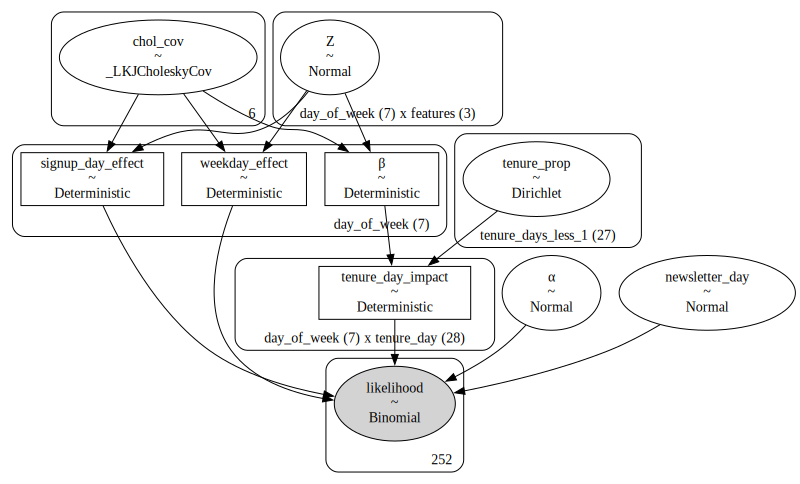

In [192]:
importlib.reload(modelling)
sc3_model = modelling.compile_pymc(
    sc3_group_df, 
    hierarchical=True, 
    priors=priors, 
    model_with_offset=False, 
    multivariate_b = True
)
pm.model_to_graphviz(
    sc3_model, 
    var_names=['likelihood']
)

In [193]:
sc3_trace = modelling.fit_pymc(
    rng=np.random.default_rng(52), 
    model = sc3_model, 
    target_accept=0.95
)

In [255]:
plotting.plot_rhats(sc3_trace)

alt.LayerChart(...)

The model takes a bit longer to run (~40 seconds), but converges without major issues. Trace plots look good, too.

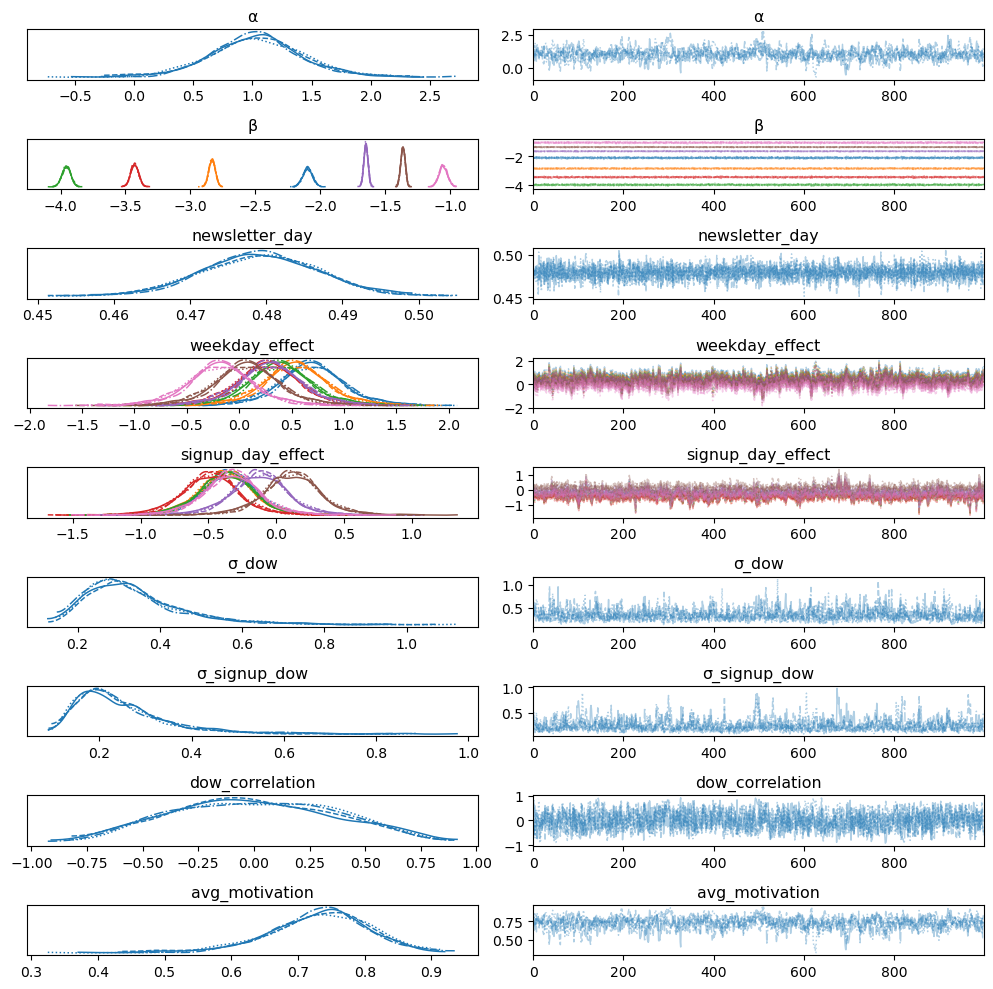

In [256]:
plotting.plot_trace(sc3_trace)

What about the effects? Here's how they look. Beautiful, isn't it?

In [253]:
hdis = az.hdi(
    sc3_trace, var_names=['δtenure_impact']
).to_dataframe().reset_index().pivot(
    index=['day_of_week', 'tenure_day'], columns='hdi', values='δtenure_impact'
)
mean = sc3_trace['posterior']['δtenure_impact'].mean(dim=['chain', 'draw']).to_dataframe()

tenure_effects_learned = hdis.join(mean).reset_index().rename(
    {
        'δtenure_impact': 'impact',
        'tenure_day': 'values',
        'day_of_week': 'factor'
    }, 
    axis=1
)
tenure_effects_learned['source'] = 'Bayesian'
tenure_effects_learned['variable'] = 'tenure_day'

ground_truth = sc3_gtExt.extract_tenure_effects(offset=False, multi=True)

tenure_effects = pd.concat([tenure_effects_learned, ground_truth])

In [258]:
c = alt.Chart(tenure_effects).encode(
    alt.X('values', title='tenure day'),     
    alt.Color('source')
)

(c.mark_area(opacity=0.5).encode(
    alt.Y('lower', title='Δ visit probability'), 
    alt.Y2('higher', title='Δ visit probability'),     
) + c.mark_line().encode(
    alt.Y('impact', title='Δ visit probability'), 
).properties(width=80, height=150)).facet(alt.Column('factor', sort=WEEKDAYS)).properties(
    title='Varying tenure effects (as a function of day of signup)',
)

alt.FacetChart(...)

# It's a wrap

This post took muuuuuch longer than expected. My personal takeaway is that:
 * Bayesian models are great, but only when you need the complexity they can support (last scenario is the best example) or you know you'll need flexible uncertainty estimates. I haven't done much of the later in this post, but answering questions such as "How much more likely is it that a user who signed up on Friday will make at least 10 visits in the first 28 days than one who signed up on Monday?" is a breeze in Bayesian setting. In other settings, the ROI may just not be there.
 * Priors matter, but not so much. I could have used `N(0,5)` priors for most of analysis in this blog post, and fiddling with step size instead could have been sufficient. I would have had to deal with more divergences, but depending on robustness I am looking for, it may have been OK.
 * Reasoning about priors is not that hard, but prior predictive simulations are your friend. Without them, I would have never realized what less informative priors really imply in these models. They may have been been uninformative individually, but due to logit link, they were very informative in the probability space.

That's the objective conclusions. 

Subjectively, I find it very satisfying about putting together a custom model that represents a structure I believe in. It's like playing with LEGO - you start small, but your imagination (and computational power) is the limit. In this case, one could add other seasonality effects, vary tenure curve shapes, capture individual-level effects. And it wouldn't be just throwing an ever increasing number of indicator variables together. 

To me, that's the beauty of Bayesian models - they allow modelling complexity without losing interpretability. I think they have their place in one's modelling toolkit for situations when simple GLMs don't cut it, but ML methods are not appropriate, either. 

